In [35]:
import calendar
import datetime
import importlib 
import numpy as np
import os
import sys
from datetime import timedelta
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from parcels import Field, FieldSet, ParticleSet, Variable, JITParticle

sys.path.append('/home/vicentev/projects/def-allen/vicentev/analysis-vicente/OP_nibi')
from OP_functions_nibi import *

In [55]:
# Defining parameters from yaml file:
config_yaml = ['/home/vicentev/projects/def-allen/vicentev/analysis-vicente/OP_nibi/config_files/config_file_test.yaml']
param = load_config(config_yaml)
#Timing definitions
start_simulation = datetime.datetime(param['release_params']['start_sim_year'], param['release_params']['start_sim_month'], param['release_params']['start_sim_day']) #Start date simulation
start_release = datetime.datetime(param['release_params']['year_start_release'], param['release_params']['month_start_release'], param['release_params']['day_start_release']) #Start date release
day_release = param['release_params']['days_of_release'] # how many days to release particles
release_freq = param['release_params']['release_particles_freq'] # release frequency in seconds
length = param['release_params']['simulation_length'] # Simulatio length in days
delta_t = param['release_params']['delta_t'] # Processes resolution in seconds
n_outputs = param['release_params']['number_outputs'] # number of output observations
#
# Iona Constants Definitions
lon_iona = param['constants']['lon_iona'] # Longitude coordinate
lat_iona = param['constants']['lat_iona'] # Latitude coordinate
depth_iona = param['constants']['depth_iona'] # Depth of release
fraction_colloidal = param['constants']['fraction_colloidal'] # fraction of particles released in colloidal phase
#
# Particles Features
vel_sewage = param['particles_features']['sinking_vel_sewage'] # sinking vel of sewage particles
vel_marine = param['particles_features']['sinking_vel_marine'] # sinking vel of marine particles
absorption = param['particles_features']['absorption'] # absorption of colloidal to marine particles
ratio_MC = param['particles_features']['ratio_marine_colloidal'] # ratio between colloidal and marine particles in the WC
fraction_sediment = param['particles_features']['fraction_sediment'] # fraction of colloidal to marine particles in the sediment
#
# Grid Parameters
deg2met = param['grid_params']['deg2met'] # conversion from degrees to meters
latT = param['grid_params']['latT'] 
dx_lat = param['grid_params']['dx_lat']
dx_lon = param['grid_params']['dx_lon']
dy_lat = param['grid_params']['dy_lat']
dy_lon = param['grid_params']['dy_lon']
#
# Resuspension Parameters
kappa = param['resuspension_params']['kappa']
zo = param['resuspension_params']['zo']
rho = param['resuspension_params']['rho']
cdmin = param['resuspension_params']['cdmin']
cdmax = param['resuspension_params']['cdmax']
tau_crit = param['resuspension_params']['tau_critical'] # critical resuspension tau value
#
# Name Extension Simulation
extension = param['name_extension']


In [57]:
 # 30  # number of days to release particles
data_length = max(length, 1)
duration = datetime.timedelta(days=length)
delta_t = 5  # seconds

number_particles = int(min(length, day_release) * 86400 / release_freq)
print("number_particles", number_particles)

output_interval = datetime.timedelta(seconds=length * 86400 / n_outputs)

number_particles 96


In [58]:
seconds_initial = (start_release - start_simulation).total_seconds()

In [59]:
start_simulation.day

1

In [63]:
release_freq * number_particles

86400

In [64]:
np.arange(seconds_initial, seconds_initial + (release_freq * number_particles), release_freq)

array([ 86400.,  87300.,  88200.,  89100.,  90000.,  90900.,  91800.,
        92700.,  93600.,  94500.,  95400.,  96300.,  97200.,  98100.,
        99000.,  99900., 100800., 101700., 102600., 103500., 104400.,
       105300., 106200., 107100., 108000., 108900., 109800., 110700.,
       111600., 112500., 113400., 114300., 115200., 116100., 117000.,
       117900., 118800., 119700., 120600., 121500., 122400., 123300.,
       124200., 125100., 126000., 126900., 127800., 128700., 129600.,
       130500., 131400., 132300., 133200., 134100., 135000., 135900.,
       136800., 137700., 138600., 139500., 140400., 141300., 142200.,
       143100., 144000., 144900., 145800., 146700., 147600., 148500.,
       149400., 150300., 151200., 152100., 153000., 153900., 154800.,
       155700., 156600., 157500., 158400., 159300., 160200., 161100.,
       162000., 162900., 163800., 164700., 165600., 166500., 167400.,
       168300., 169200., 170100., 171000., 171900.])

In [66]:
np.arange(0,2* release_freq * number_particles, release_freq)

array([     0,    900,   1800,   2700,   3600,   4500,   5400,   6300,
         7200,   8100,   9000,   9900,  10800,  11700,  12600,  13500,
        14400,  15300,  16200,  17100,  18000,  18900,  19800,  20700,
        21600,  22500,  23400,  24300,  25200,  26100,  27000,  27900,
        28800,  29700,  30600,  31500,  32400,  33300,  34200,  35100,
        36000,  36900,  37800,  38700,  39600,  40500,  41400,  42300,
        43200,  44100,  45000,  45900,  46800,  47700,  48600,  49500,
        50400,  51300,  52200,  53100,  54000,  54900,  55800,  56700,
        57600,  58500,  59400,  60300,  61200,  62100,  63000,  63900,
        64800,  65700,  66600,  67500,  68400,  69300,  70200,  71100,
        72000,  72900,  73800,  74700,  75600,  76500,  77400,  78300,
        79200,  80100,  81000,  81900,  82800,  83700,  84600,  85500,
        86400,  87300,  88200,  89100,  90000,  90900,  91800,  92700,
        93600,  94500,  95400,  96300,  97200,  98100,  99000,  99900,
      

In [67]:
data0 = xr.open_dataset('/home/vicentev/scratch/vicentev/Simulations_Runs/PBDEs_0112007_run_1_days_testing_sim_1_day.zarr', engine = 'zarr')
data1 = xr.open_dataset('/home/vicentev/scratch/vicentev/Simulations_Runs/PBDEs_0112007_run_2_days_testing_sim_2_day.zarr', engine = 'zarr')

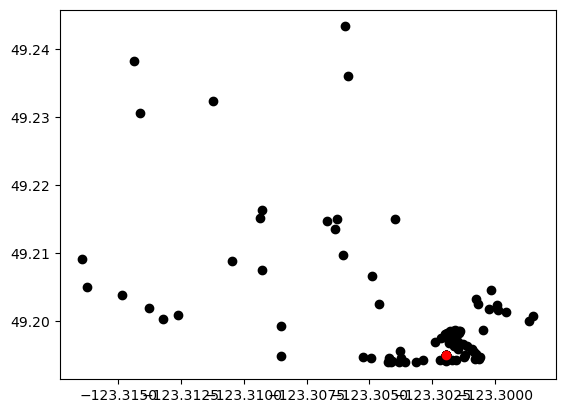

In [78]:
t = 23
plt.scatter(data1.lon[:,t], data1.lat[:,t], c = 'k')
plt.scatter(lon_iona, lat_iona, c = 'r')

In [79]:
data_restart = xr.open_dataset('/home/vicentev/scratch/vicentev/Simulations_Runs/RESTART_Runs/PBDEs_0112007_run_2_days_testing_sim_2_day_restart_2_days_testing_restart.zarr', engine = 'zarr')

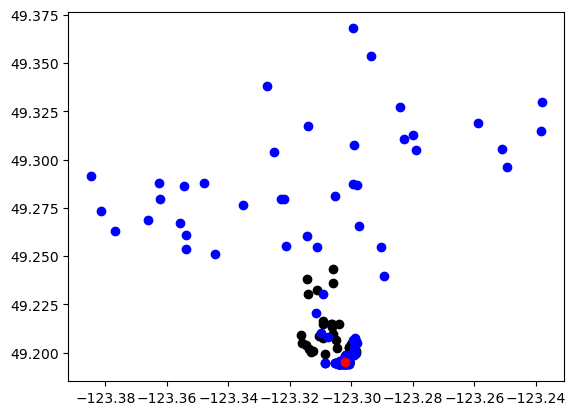

In [88]:
t0 = 23
t1 = 23

plt.scatter(data1.lon[:,t0], data1.lat[:,t0], c = 'k')
plt.scatter(data_restart.lon[:,t1], data_restart.lat[:,t1], c = 'b')

plt.scatter(lon_iona, lat_iona, c = 'r')

In [89]:
data_test = xr.open_dataset('/home/vicentev/scratch/vicentev/Simulations_Runs/PBDEs_0112007_run_1_days_testing_sim_1.zarr', engine = 'zarr')

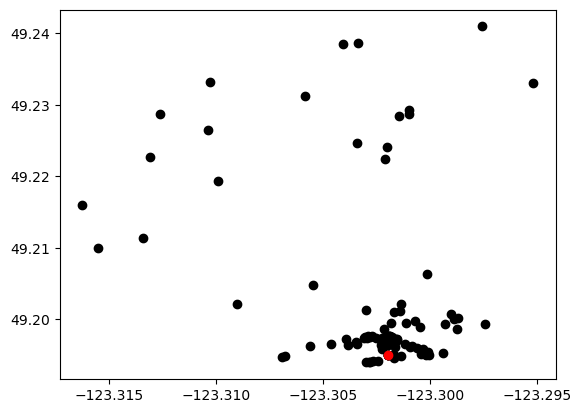

In [98]:
t = 23
plt.scatter(data_test.lon[:,t], data_test.lat[:,t], c = 'k')
plt.scatter(lon_iona, lat_iona, c = 'r')